Similarly, if you want to see view counts on your Kaggle notebooks - you have to increase the view count by one... *until now!* We can spy on the latest view counts (and other stats) by requesting a listing from the Kaggle API...

To use this notebook:

 1.   Fork this notebook by clicking on Copy and Edit.
 2.   Set the username variable to your own username.

In [1]:
username = 'azminetoushikwasi'

In [2]:
from IPython.display import Markdown, display
import datetime, requests, json, os, re, sys, time
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

session = requests.session()
profile = session.get('https://www.kaggle.com/' + username)
session.headers['x-xsrf-token'] = session.cookies['XSRF-TOKEN']

uid = int(re.findall('Kaggle\.State\.push\({.*?"userId":(\d+),', profile.text)[0])
count = int(re.findall('"scriptsSummary":{.*?"totalResults":(\d+),', profile.text)[0])
pages = int(np.ceil(count / 20))

In [3]:
url = 'https://www.kaggle.com/api/i/kernels.KernelsService/ListKernels'
request = {
    'kernelFilterCriteria': {
        'search': '',
        'listRequest': {
            'userId': 0,
            'sortBy': 'DATE_RUN',
            'pageSize': 20,
            'group': 'PROFILE',
            'page': 1,
            'tagIds': '',
            'excludeResultsFilesOutputs': False,
            'wantOutputFiles': False
        }
    },
    'detailFilterCriteria': {
        'deletedAccessBehavior': 'RETURN_NOTHING',
        'unauthorizedAccessBehavior': 'RETURN_NOTHING',
        'excludeResultsFilesOutputs': False,
        'wantOutputFiles': False,
        'kernelIds': [],
        'outputFileTypes': []
    }
}

In [4]:
request['kernelFilterCriteria']['listRequest']['userId'] = uid

dfs = []
for page in range(1, pages + 1):
    request['kernelFilterCriteria']['listRequest']['page'] = page
    data = json.dumps(request, separators=(',', ':'))
    res = session.post(url, data=data)
    #print(page, res.status_code, len(res.text))
    if res.status_code != 200:
        break
    df = pd.DataFrame(json.loads(res.text)['kernels'])
    dfs.append(df)

def split_columns(df, col):
    values = df.pop(col)
    return df.join(values.apply(pd.Series).add_prefix(col + "_"))

df = pd.concat(dfs, ignore_index=True)
df = split_columns(df, 'author')
df = split_columns(df, 'dataSources')
df = split_columns(df, 'categories')

filename = f'{username}-{datetime.datetime.now().strftime("%Y-%m-%d")}.csv'
df.to_csv("./data/"+filename, index=False)

display(Markdown(f"""
 - Notebook count: {df.shape[0]:,.0f}
 - Total views: {df.totalViews.sum():,.0f}
 - Total comments: {df.totalComments.sum():,.0f}
 - Total medals: {df.medal.count():,.0f}
 - Total votes: {df.totalVotes.sum():,.0f}
 - Mean views per vote: {df.totalViews.sum() / df.totalVotes.sum():,.0f}
"""))


 - Notebook count: 10
 - Total views: 10,673
 - Total comments: 178
 - Total medals: 10
 - Total votes: 429
 - Mean views per vote: 25


In [5]:
display(Markdown(f'# Notebooks by {df.author_displayName.get(0)}'))
df['viewsPerVote'] = df.eval('(totalViews+1)/(totalVotes+1)')
df['lastRun'] = pd.to_datetime(df.lastRunTime).dt.strftime('%c')
stats = ['totalViews', 'totalVotes', 'totalLines', 'totalComments']
links = ('<a href="https://www.kaggle.com' + df.scriptUrl + '" '
         + ' title="'
         + 'Language: ' + df.languageName.fillna('N/A') + '\n'
         + 'Medal: ' + df.medal.fillna('N/A') + '\n'
         + 'Last run: ' + df.lastRun + '\n'
         + 'Runtime: ' + df.lastRunExecutionTimeSeconds.map(str) + 's' + '\n'
         + 'Views per vote: ' + df.eval('(totalViews+1)/(totalVotes+1)').apply(lambda x: f'{x:,.0f}')
         + '">' # end title="..."
         + df.title
         + '</a>')
show = df[['title'] + stats].copy()
show['title'] = links
show.style.format({k:'{:,.0f}' for k in stats}, na_rep="").hide_index().bar(width=50, color='#4cf')

# Notebooks by Azmine Toushik Wasi

title,totalViews,totalVotes,totalLines,totalComments
"Divorce 💥 XGBoost 📊 PCA Analysis with SHAP,TSNE",626,33,484,13
▶️ Cristiano Ronaldo 📊 Extended EDA ⚽ Goals,"1,675",40,274,30
➡️ Tutorial ✅ 07 Cross Validation Methods 📊,888,42,344,10
▶️ Lionel Messi 📊 Extended EDA ⚽ Goals,"1,298",46,380,21
UCL ⚽ EDA & Viz ⭐ 2021-22 ⭐ Players & Teams,"1,045",35,536,17
➡️ Intro to Imputation 🔍 Different Techniques,"2,739",112,357,22
🛠 Feature Engineering ➡️ Tutorial ⚙ Housing Data,715,36,354,16
📋 Bias-Variance Tradeoff ➡️ with NumPy & Seaborn,554,28,596,18
"📘 Coursera 📉 EDA, FE 📈 Analysis + Insights 📊",482,27,279,16
Export Processing Zones - EDA+Statistical Analysis,651,30,461,15


# Plotly Scatter Plot

You may want to tweak these settings depending on how many notebooks you have...


In [6]:
import plotly.express as px

df['totalComments'].fillna(0, inplace=True)
df['medal'].fillna('N/A', inplace=True)
df['size'] = df['totalComments'].clip(lower=1)
color_map = {
    'GOLD': 'gold',
    'SILVER': 'silver',
    'BRONZE': 'chocolate',
    'N/A': '#333'
}
px.scatter(
    df,
    'totalViews',
    'totalVotes',
    title=f'Notebooks by {df.author_displayName.get(0)}',
    log_x=False,
    log_y=False,
    color='medal',
    color_discrete_map=color_map,
    size='size',
    trendline='ols',
    trendline_options=dict(log_x=True, log_y=True, add_constant=False),
    #trendline='lowess', # Use for Locally Weighted Scatterplot Smoothing line
    #trendline_scope='overall', # Use this for one trendline
    hover_name='title',
    hover_data={
        'size': False,
        'totalViews': ':,.0f',
        'totalVotes': ':,.0f',
        'totalLines': ':,.0f',
        'totalComments': ':,.0f',
        'viewsPerVote': ':,.0f',
        'languageName': True,
        'versionNumber': True,
        'lastRun': True,
        'lastRunExecutionTimeSeconds': ':,.0f',
        'medal': True,
    })

# Analysis

In [7]:
links=[]
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        link=os.path.join(dirname, filename)
        links.append(link)

In [8]:
dfx=pd.DataFrame()
date_list=[]
titles_dft=[]
date_dft=[]
count_dft=[]
view_dft=[]

gTotalUpvotes=[]
gTotalViews=[]
gTotalComments=[]


for link in links:
    date=link[25:35]
    date_list.append(date)
    temp_df=pd.read_csv(link)
    
    gTotalUpvotes.append(temp_df.totalVotes.sum())
    gTotalViews.append(temp_df.totalViews.sum())
    gTotalComments.append(temp_df.totalComments.sum())
    
    temp_titles=list(temp_df.title)
    temp_totalVotes=list(temp_df.totalVotes)
    temp_totalViews=list(temp_df.totalViews)
    
    for name in temp_titles:
        titles_dft.append(name)
        date_dft.append(date)
        count_dft.append(temp_totalVotes[temp_titles.index(name)])
        view_dft.append(temp_totalViews[temp_titles.index(name)])


df_d={"title":titles_dft, "date":date_dft, "count":count_dft,"view_count":view_dft}
df_d=pd.DataFrame(df_d)


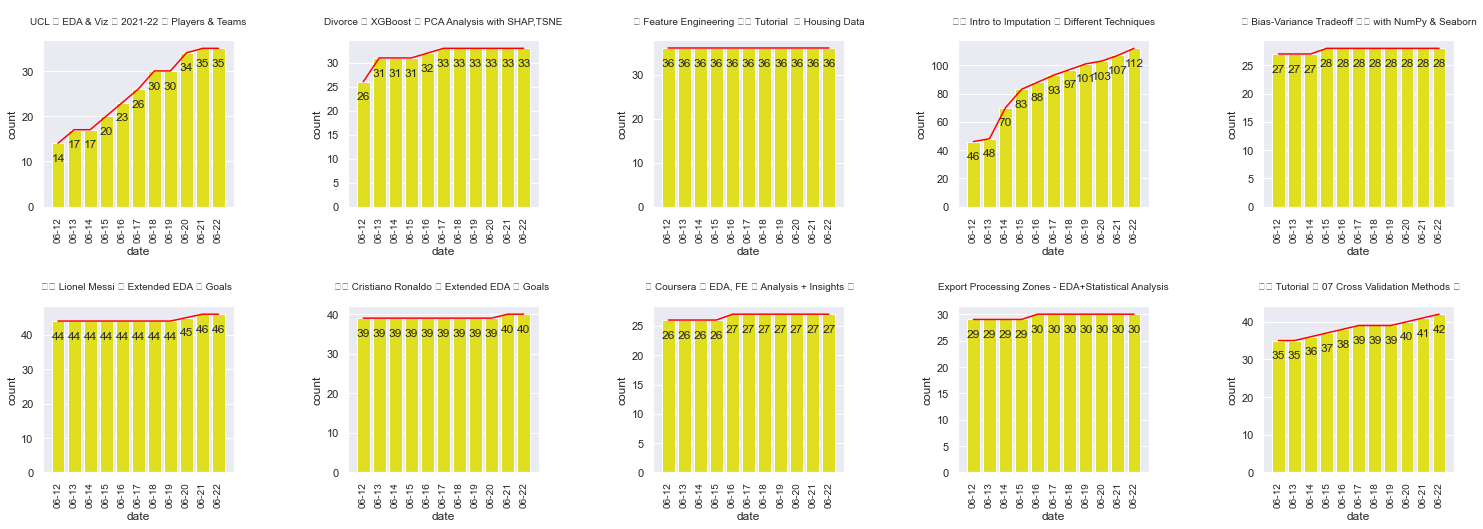

In [9]:
w=5
h=math.ceil(len(list(df_d.title.unique()))/w)

sns.set(rc={'figure.figsize':(28,h*6)})
for i, column in enumerate(list(df_d.title.unique()), 1):

    plt.subplot(h,w,i)
    plt.subplots_adjust(left=0.2,
                    bottom=0.4, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
    tdx=df_d[df_d['title']==column]
    tdx['date']=tdx['date'].str[5:]
    p=sns.barplot(x='date',data=tdx,y='count',color="yellow")
    plt.xticks(fontsize=10,rotation='vertical')
    p.axes.set_title("\n"+str(column)+"\n",fontsize=10);
    p.bar_label(p.containers[len(p.containers)-1],label_type='edge',padding=-20)
    p=sns.lineplot(x='date',data=tdx,y='count',color='red')

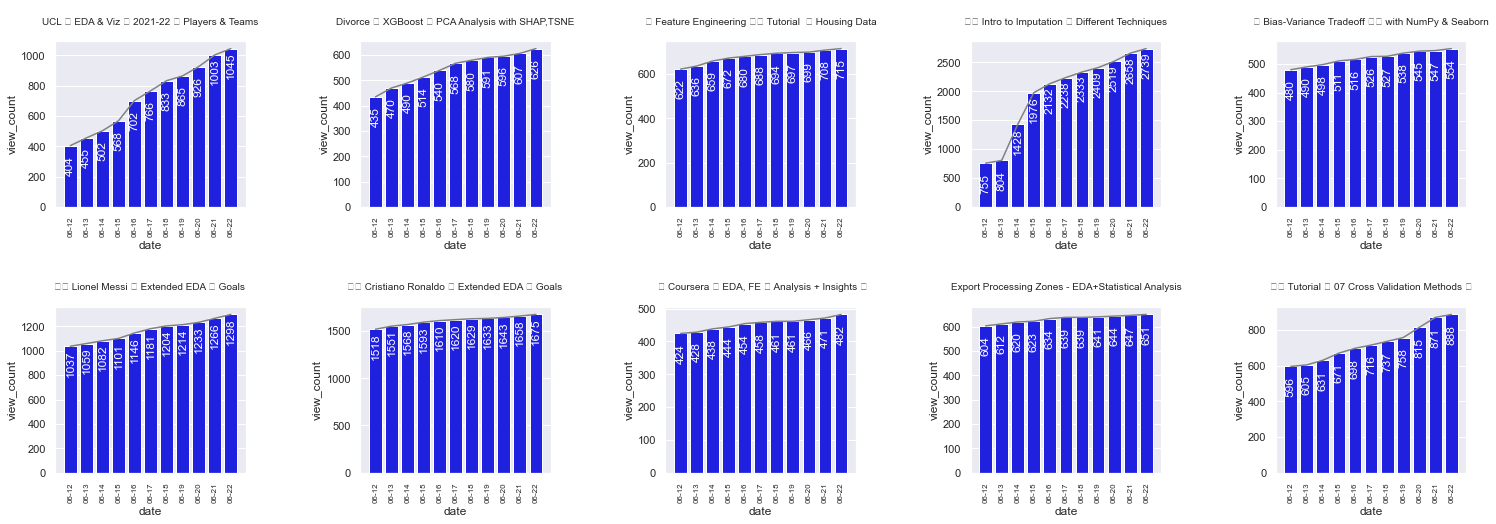

In [10]:
w=5
h=math.ceil(len(list(df_d.title.unique()))/w)

sns.set(rc={'figure.figsize':(28,h*6)})
for i, column in enumerate(list(df_d.title.unique()), 1):

    plt.subplot(h,w,i)
    plt.subplots_adjust(left=0.2,
                    bottom=0.4, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
    tdx=df_d[df_d['title']==column]
    tdx['date']=tdx['date'].str[5:]
    p=sns.barplot(x='date',data=tdx,y='view_count',color='blue')
    plt.xticks(fontsize=8,rotation='vertical')
    p.axes.set_title("\n"+str(column)+"\n",fontsize=10);
    p.bar_label(p.containers[len(p.containers)-1],label_type='edge',padding=-30,rotation='vertical',fontsize=12,color='white')
    p=sns.lineplot(x='date',data=tdx,y='view_count',color='grey')


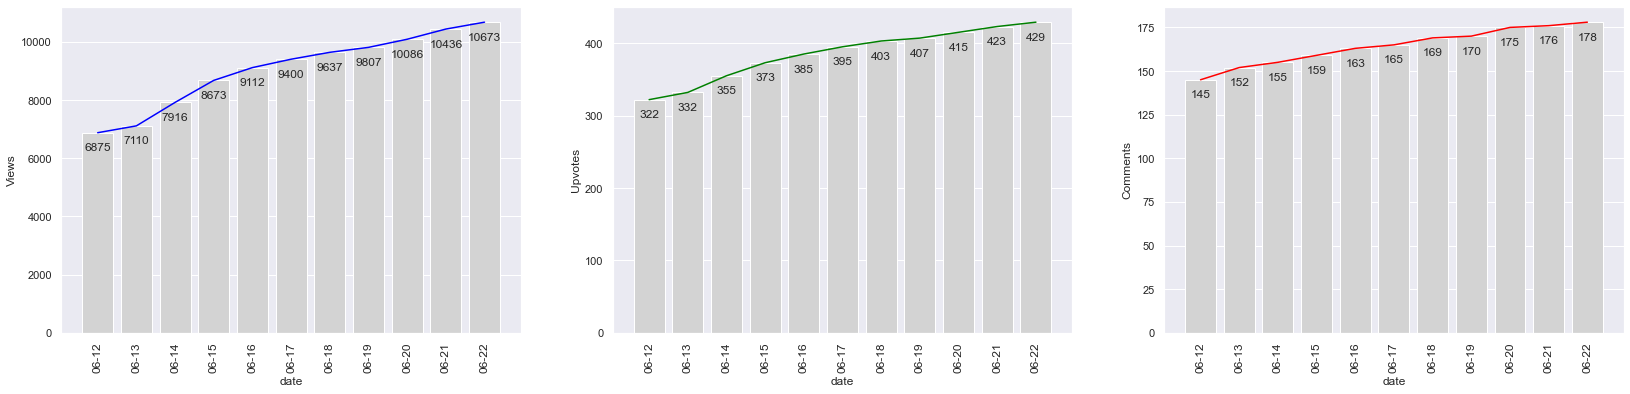

In [11]:
totals={'date':date_list,"Upvotes":gTotalUpvotes,"Views":gTotalViews,"Comments":gTotalComments}
totals=pd.DataFrame(totals)
totals['date']=totals['date'].str[5:]


sns.set(rc={'figure.figsize':(28,6)})

plt.subplot(1,3,1)
p=sns.barplot(x='date',data=totals,y='Views',color='lightgrey')
p.bar_label(p.containers[len(p.containers)-1],label_type='edge',padding=-20)
sns.lineplot(x='date',data=totals,y="Views",color='blue')
plt.xticks(fontsize=12,rotation='vertical')

plt.subplot(1,3,2)
p=sns.barplot(x='date',data=totals,y='Upvotes',color='lightgrey')
p.bar_label(p.containers[len(p.containers)-1],label_type='edge',padding=-20)
sns.lineplot(x='date',data=totals,y="Upvotes",color='green')
plt.xticks(fontsize=12,rotation='vertical')

plt.subplot(1,3,3)
p=sns.barplot(x='date',data=totals,y='Comments',color='lightgrey')
p.bar_label(p.containers[len(p.containers)-1],label_type='edge',padding=-20)
sns.lineplot(x='date',data=totals,y="Comments",color='red')
plt.xticks(fontsize=12,rotation='vertical');